In [61]:

import numpy
import matplotlib.pyplot as plt
import scipy
import json

In [62]:
# bag utils
import rosbag
from sensor_msgs.msg import JointState
import os

def read_bag(bagdir):
    bag = rosbag.Bag(bagdir,'r')
    messages = []
    for _,msg,_ in bag.read_messages(topics=['/my_gen3_lite/joint_states']):
        temp = JointState()
        temp.header = msg.header
        temp.position = msg.position
        temp.velocity = msg.velocity
        temp.name = msg.name
        temp.effort = msg.effort
        messages.append(temp)
    # print("messages length: ",len(messages))
    return messages

def get_all_bag_files(file_path:str=None):
    if file_path is not None:
        file_dir = file_path
    else:
    # use default bag file location
        bag_file_list = []
        file_dir = os.path.dirname(
                os.path.dirname(
                    os.path.abspath('')
        ))
        file_dir = os.path.join(file_dir,"scripts/bags/")
        print(file_dir)
    # look through directory to find all bag files
    for root, dirs, files in os.walk(file_dir):
        for file in files:
            if file.endswith(".bag"):
                bag_file_list.append(os.path.join(root,file))
    return bag_file_list

# read a list of bags, then convert them into a list of messages
def whole_bag_to_messages(bag_file_list):
    messages_list= []
    for i in range(len(bag_file_list)):
        messages = read_bag(bag_file_list[i])
        messages_list.append(messages)
    return messages_list


# read json file
def read_json(json_file_name, json_file_path:str=None):
    if json_file_path is not None:
        json_file = os.path.join(json_file_path,json_file_name)
    else:
        json_file = os.path.join(
            os.path.dirname(
                os.path.dirname(
                    os.path.abspath('')
                )
            ),
            "scripts/annotations/",
            json_file_name
        )
    with open(json_file) as f:
        data = json.load(f)
    return data

In [63]:
# calculate transition matrix with DH parameters
def transf_dh(a, alpha, d, theta):
    # input degrees, output radians
    alpha = numpy.deg2rad(alpha)
    theta = numpy.deg2rad(theta)
    return numpy.array([
        [numpy.cos(theta), -numpy.sin(theta)*numpy.cos(alpha), numpy.sin(theta)*numpy.sin(alpha), a*numpy.cos(theta)],
        [numpy.sin(theta), numpy.cos(theta)*numpy.cos(alpha), -numpy.cos(theta)*numpy.sin(alpha), a*numpy.sin(theta)],
        [0, numpy.sin(alpha), numpy.cos(alpha), d],
        [0, 0, 0, 1]
    ])

def forward_kinematics(q):
    # q is a nx6
    end_effector_pose = numpy.zeros((len(q), 6))
    for i in range(len(q)):
        # q radian to degree
        q[i] = numpy.rad2deg(q[i])
        T56=transf_dh(0,0,0.105+0.130,q[i,5]+90)
        T45=transf_dh(0,90,0.0285*2,q[i,4]+180)
        T34=transf_dh(0,90,0.140+0.105,q[i,3]+90)
        T23=transf_dh(0,90,0.020,q[i,2]+90)
        T12=transf_dh(0.280,180,0.030,q[i,1]+90)
        T01=transf_dh(0,90,0.1283+0.115,q[i,0])
        T06 = T01.dot(T12).dot(T23).dot(T34).dot(T45).dot(T56)
        # get position and orientation
        end_effector_pose[i,0:3] = T06[0:3,3]
        # get row pitch yaw
        scipy.spatial.transform.Rotation.from_matrix(T06[0:3,0:3]).as_euler('zyx')
        end_effector_pose[i,3:6] = scipy.spatial.transform.Rotation.from_matrix(T06[0:3,0:3]).as_euler('zyx')
    return end_effector_pose





In [64]:
bag_file_list = get_all_bag_files()
bag_file_list = [bag_file for bag_file in bag_file_list if "user_32/" in bag_file]
print(bag_file_list)
message_list = whole_bag_to_messages(bag_file_list)
json_file_name = "user_32.json"
# open corresponding json file
annotation_dict = read_json(json_file_name)

print(type(message_list[0][0].position))
jar_pose = [0.126, 0.29, 0.11]


/home/shijie-fang/human_error/human-error/src/replayer/scripts/bags/
['/home/shijie-fang/human_error/human-error/src/replayer/scripts/bags/user_32/0.bag']
<class 'tuple'>


In [65]:
# calculate forward kinematics
q = numpy.zeros((len(message_list[0]),6))
print(q.shape)
for i in range(len(message_list[0])):
    q[i] = numpy.array(message_list[0][i].position[:6])
end_effector_pose = forward_kinematics(q)
print(end_effector_pose.shape)

(528, 6)
(528, 6)


[0.33, -0.14]


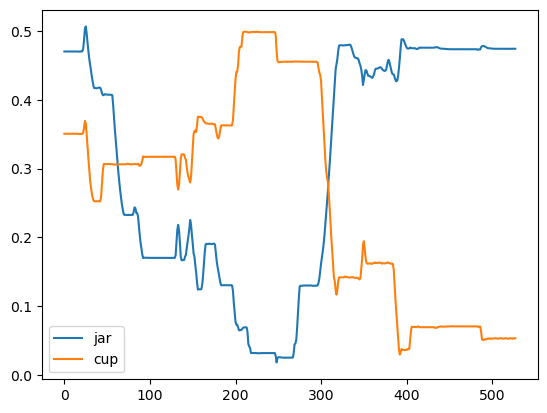

In [66]:
# jar_pose = end_effector_pose[60,:3]
# look for end in json file
for i in range(len(annotation_dict)):
    if "actions_after_this_behavior" in annotation_dict[i].keys() and annotation_dict[i]["actions_after_this_behavior"] == "end":
        cup_pose_index = annotation_dict[i]["step"]
        break
cup_xy_pose = [0.33, -0.14]
pour_pose = end_effector_pose[cup_pose_index,:3]
print(cup_xy_pose)
# plot distance to jar
distance = numpy.linalg.norm(end_effector_pose[:,0:3]-jar_pose,axis=1)
distance_jar_xz = numpy.linalg.norm(end_effector_pose[:,[0,2]]-numpy.array(jar_pose)[[0,2]],axis=1)
distance_pour= numpy.linalg.norm(end_effector_pose[:,0:3]-pour_pose,axis=1)
distance_cup = numpy.linalg.norm(end_effector_pose[:,0:2]-cup_xy_pose,axis=1)
distance_cup_l1 = (end_effector_pose[:,0:2]-cup_xy_pose).sum(axis=1)
plt.plot(distance)
plt.plot(distance_cup)
plt.legend(["jar","cup"])
# plot 400-last 


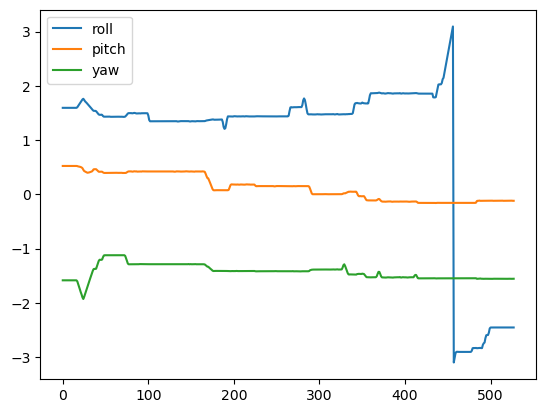

In [67]:
# plot the euler angles
plt.figure()
plt.plot(end_effector_pose[:,3])
plt.plot(end_effector_pose[:,4])
plt.plot(end_effector_pose[:,5])
# add legend
plt.legend(['roll','pitch','yaw'])
plt.show()

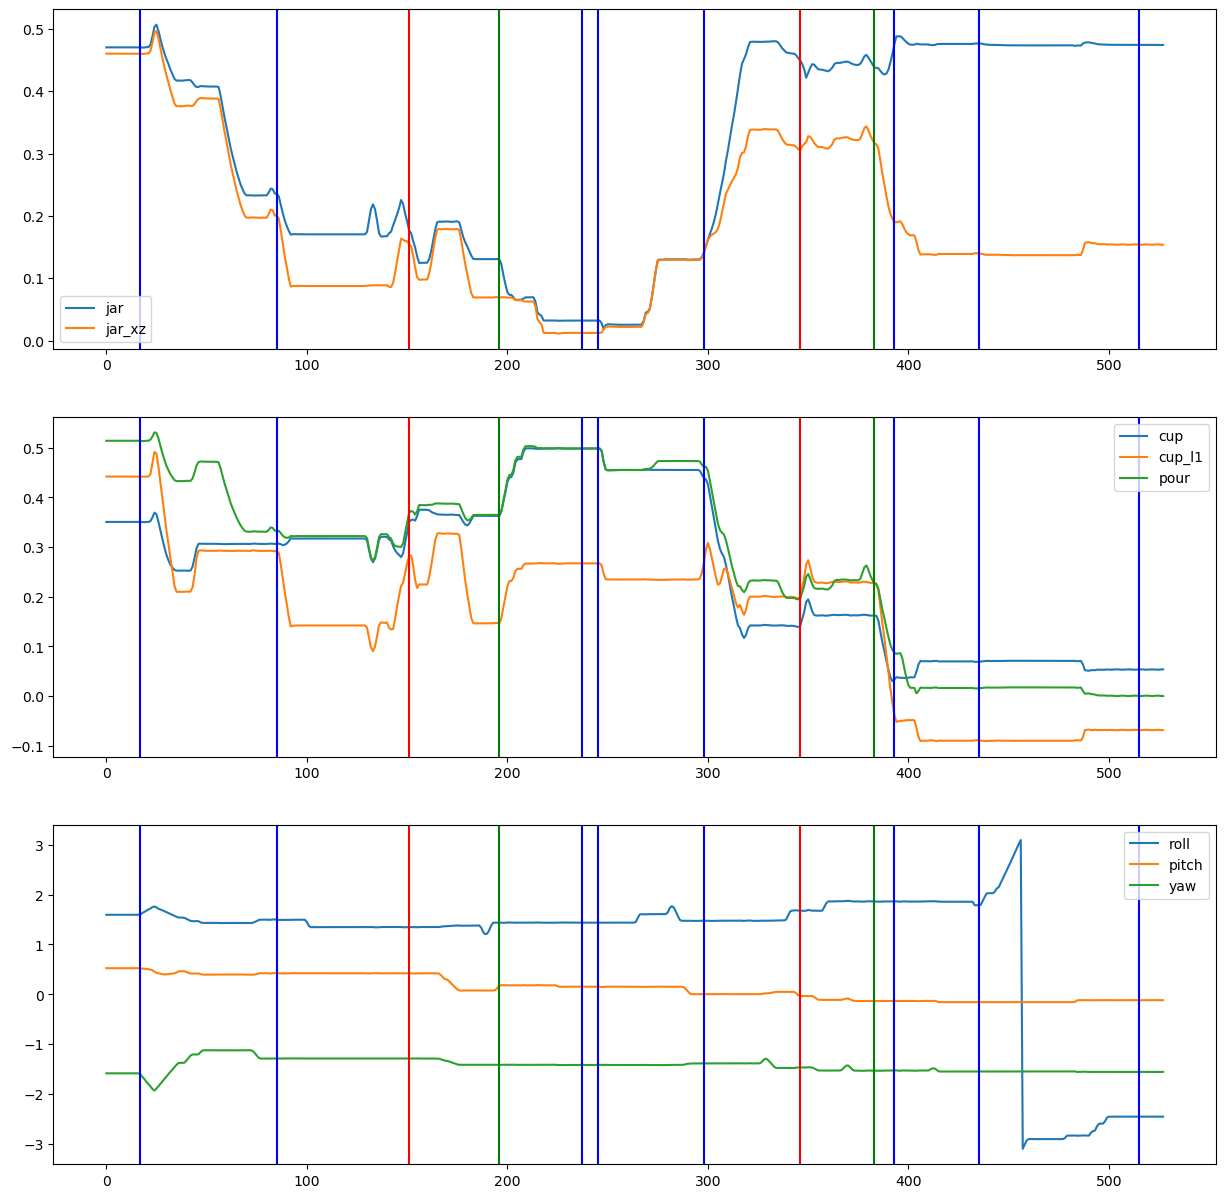

In [68]:

# annotation is a list of dictionary
# each dictionary has a action_step_start and action_step_end key
# mark these keys on the plot

def clear_pause_steps(end_effector_pose, step, step_end):
    # check whether poses after step is same as the one before step
    #  if so, move step backward
    original_step = step_end
    while numpy.abs(numpy.array(end_effector_pose[step][:5]) - numpy.array(end_effector_pose[original_step + 1][:5])).sum() < 0.02\
          and  numpy.abs(numpy.array(end_effector_pose[step][5]) - numpy.array(end_effector_pose[original_step + 1][5])) < 0.005:
        step += 1
        if step == step_end:
            break
    return step

def clear_pause_end_steps(end_effector_pose, step, step_end):
    # check whether poses after step is same as the one before step
    #  if so, move step backward
    original_step = step_end
    while numpy.abs(numpy.array(end_effector_pose[step_end][:5]) - numpy.array(end_effector_pose[original_step+1][:5])).sum() < 0.02\
          and  numpy.abs(numpy.array(end_effector_pose[step_end][5]) - numpy.array(end_effector_pose[original_step+1][5])) < 0.005:
        step_end -= 1
        if step_end == step:
            break
    return step_end
# ax[0,0] = plt.subplot(311)
fig, ax = plt.subplots(3,1, figsize=(15,15))

ax[0].plot(distance)

ax[0].plot(distance_jar_xz)
ax[0].legend(["jar","jar_xz"])
for i in range(len(annotation_dict)):
    if 'action_step_start' in annotation_dict[i]:
        annotation_dict[i]['action_step_start'] = clear_pause_steps(end_effector_pose,annotation_dict[i]['action_step_start'],annotation_dict[i]['action_step_end'])
    if 'action_step_end' in annotation_dict[i]:
        annotation_dict[i]['action_step_end'] = clear_pause_end_steps(end_effector_pose,annotation_dict[i]['action_step_start'],annotation_dict[i]['action_step_end'])

# ax2 = plt.subplot(312)
ax[1].plot(distance_cup)
ax[1].plot(distance_cup_l1)
ax[1].plot(distance_pour)
ax[1].legend(["cup","cup_l1", "pour"])

# ax3 = plt.subplot(313)
ax[2].plot(end_effector_pose[:,3])
ax[2].plot(end_effector_pose[:,4])
ax[2].plot(end_effector_pose[:,5])
ax[2].legend(['roll','pitch','yaw'])

for i in range(len(annotation_dict)):
    # if have the key
    if annotation_dict[i]['annotation'] =="test controller":
        if 'action_step_start' in annotation_dict[i]:
            ax[0].axvline(x=annotation_dict[i]['action_step_start'],color='r')
            ax[1].axvline(x=annotation_dict[i]['action_step_start'],color='r')
            ax[2].axvline(x=annotation_dict[i]['action_step_start'],color='r')
        if 'action_step_end' in annotation_dict[i]:
            ax[0].axvline(x=annotation_dict[i]['action_step_end'],color='g')
            ax[1].axvline(x=annotation_dict[i]['action_step_end'],color='g')
            ax[2].axvline(x=annotation_dict[i]['action_step_end'],color='g')
    if 'step' in annotation_dict[i]:
        ax[0].axvline(x=annotation_dict[i]['step'],color='b')
        ax[1].axvline(x=annotation_dict[i]['step'],color='b')
        ax[2].axvline(x=annotation_dict[i]['step'],color='b')

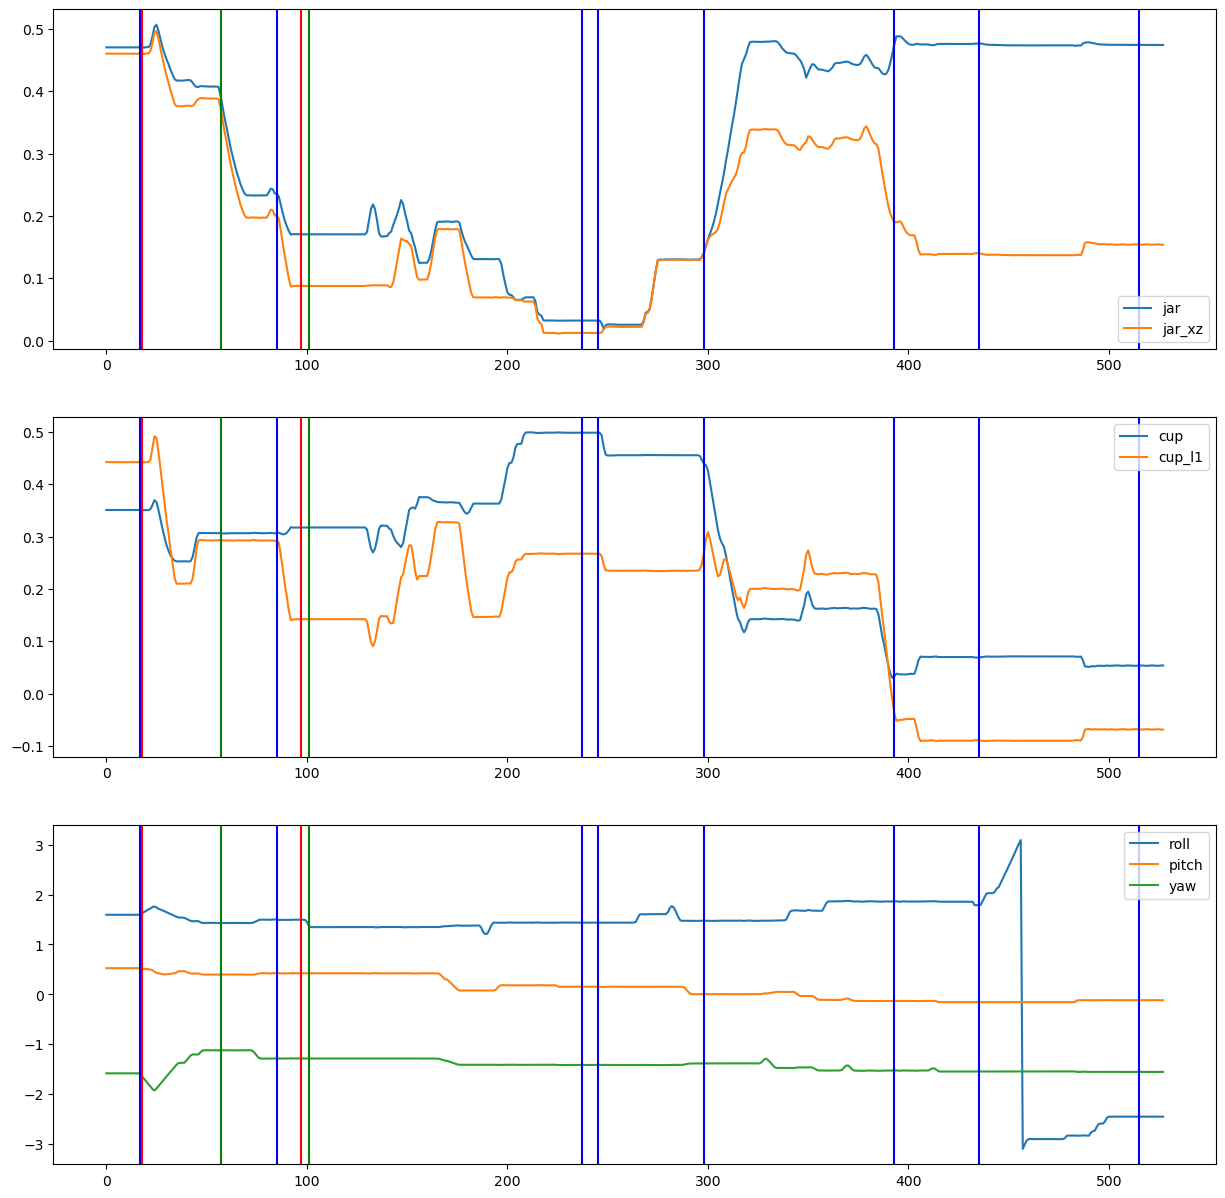

In [69]:
fig, ax = plt.subplots(3,1, figsize=(15,15))
ax[0].plot(distance)

ax[0].plot(distance_jar_xz)
ax[0].legend(["jar","jar_xz"])
for i in range(len(annotation_dict)):
    if 'action_step_start' in annotation_dict[i]:
        annotation_dict[i]['action_step_start'] = clear_pause_steps(end_effector_pose,annotation_dict[i]['action_step_start'],annotation_dict[i]['action_step_end'])
    if 'action_step_end' in annotation_dict[i]:
        annotation_dict[i]['action_step_end'] = clear_pause_end_steps(end_effector_pose,annotation_dict[i]['action_step_start'],annotation_dict[i]['action_step_end'])

# ax2 = plt.subplot(312)
ax[1].plot(distance_cup)
ax[1].plot(distance_cup_l1)
ax[1].legend(["cup","cup_l1"])

# ax3 = plt.subplot(313)
ax[2].plot(end_effector_pose[:,3])
ax[2].plot(end_effector_pose[:,4])
ax[2].plot(end_effector_pose[:,5])
ax[2].legend(['roll','pitch','yaw'])

for i in range(len(annotation_dict)):
    # if have the key
    if annotation_dict[i]['annotation'] =="false control":
        if 'action_step_start' in annotation_dict[i]:
            ax[0].axvline(x=annotation_dict[i]['action_step_start'],color='r')
            ax[1].axvline(x=annotation_dict[i]['action_step_start'],color='r')
            ax[2].axvline(x=annotation_dict[i]['action_step_start'],color='r')
        if 'action_step_end' in annotation_dict[i]:
            ax[0].axvline(x=annotation_dict[i]['action_step_end'],color='g')
            ax[1].axvline(x=annotation_dict[i]['action_step_end'],color='g')
            ax[2].axvline(x=annotation_dict[i]['action_step_end'],color='g')
    if 'step' in annotation_dict[i]:
        ax[0].axvline(x=annotation_dict[i]['step'],color='b')
        ax[1].axvline(x=annotation_dict[i]['step'],color='b')
        ax[2].axvline(x=annotation_dict[i]['step'],color='b')

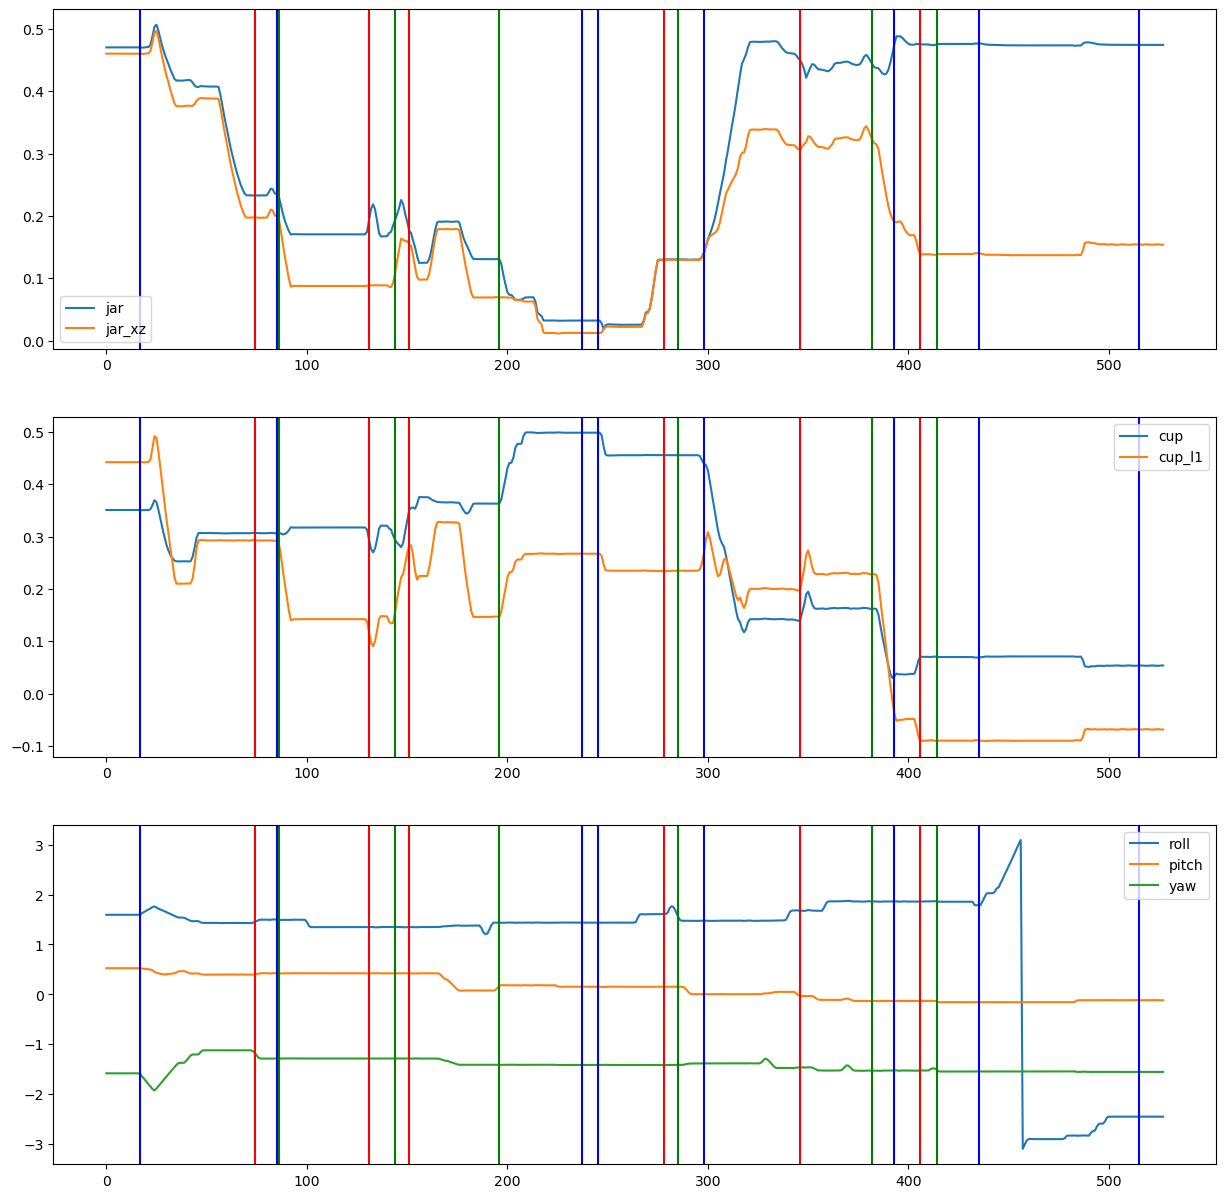

In [70]:
fig, ax = plt.subplots(3,1, figsize=(15,15))
ax[0].plot(distance)

ax[0].plot(distance_jar_xz)
ax[0].legend(["jar","jar_xz"])
for i in range(len(annotation_dict)):
    if 'action_step_start' in annotation_dict[i]:
        annotation_dict[i]['action_step_start'] = clear_pause_steps(end_effector_pose,annotation_dict[i]['action_step_start'],annotation_dict[i]['action_step_end'])
    if 'action_step_end' in annotation_dict[i]:
        annotation_dict[i]['action_step_end'] = clear_pause_end_steps(end_effector_pose,annotation_dict[i]['action_step_start'],annotation_dict[i]['action_step_end'])

# ax2 = plt.subplot(312)
ax[1].plot(distance_cup)
ax[1].plot(distance_cup_l1)
ax[1].legend(["cup","cup_l1"])

# ax3 = plt.subplot(313)
ax[2].plot(end_effector_pose[:,3])
ax[2].plot(end_effector_pose[:,4])
ax[2].plot(end_effector_pose[:,5])
ax[2].legend(['roll','pitch','yaw'])

for i in range(len(annotation_dict)):
    # if have the key
    if annotation_dict[i]['annotation'] =="alignment":
        if 'action_step_start' in annotation_dict[i]:
            ax[0].axvline(x=annotation_dict[i]['action_step_start'],color='r')
            ax[1].axvline(x=annotation_dict[i]['action_step_start'],color='r')
            ax[2].axvline(x=annotation_dict[i]['action_step_start'],color='r')
        if 'action_step_end' in annotation_dict[i]:
            ax[0].axvline(x=annotation_dict[i]['action_step_end'],color='g')
            ax[1].axvline(x=annotation_dict[i]['action_step_end'],color='g')
            ax[2].axvline(x=annotation_dict[i]['action_step_end'],color='g')
    if 'step' in annotation_dict[i]:
        ax[0].axvline(x=annotation_dict[i]['step'],color='b')
        ax[1].axvline(x=annotation_dict[i]['step'],color='b')
        ax[2].axvline(x=annotation_dict[i]['step'],color='b')